In [1]:
import os
import git
from pathlib import Path

from typing import List
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go
from IPython.display import clear_output
import pylustrator
from matplotlib.patches import Rectangle

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = True
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(os.path.join(ROOT_DIR, "results", "combined_results"))
np.random.seed(0)
plots_path = os.path.join(ROOT_DIR, "poster", "plots")

In [2]:
def variance_prior(r, eta, scale=1):
    beta = (eta+1.5)/r
    var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
    return var_prior

def kurtosis_prior(r, eta, fisher=True):
    beta = (eta+1.5)/r
    kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2 
    if fisher:
        return kurtosis - 3
    else:
        return kurtosis 

fixed_palette = {
    'gray': 'xkcd:gray',
    'green': 'xkcd:shamrock green',
    'red': 'xkcd:light red',
    'blue': 'xkcd:blue',
}

def find_master_dfs(root_dir: str) -> List[str]:
    root_path = Path(root_dir)
    if not root_path.exists():
        raise FileNotFoundError(f"Directory not found: {root_dir}")

    master_df_paths = []
    for current_dir, _, files in os.walk(root_path):
        if 'master_df.csv' in files:
            master_df_path = Path(os.path.join(current_dir, 'master_df.csv'))
            master_df_paths.append(str(master_df_path.absolute()))
    return master_df_paths

relevant_cols = ['group', 'obs_var', 'var_lower', 'var_upper', 'obs_kurt', 'kurt_lower',
       'kurt_upper', 'total_samples', 'initial_r', 'initial_eta',
       'kstest_stat_initial', 'kstest_stat_cutoff_0.05',
       'best_r', 'best_eta', 'kstest_stat_best', 'param_gaussian',
       'kstest_stat_gaussian', 'kstest_pval_gaussian', 'param_laplace',
       'kstest_stat_laplace', 'kstest_pval_laplace', 'param_t',
       'kstest_stat_t', 'kstest_pval_t', 'kstest_pval_gengamma', 'dataset', 'subset', 'transform', 'orientation', 'channel']


all_paths = find_master_dfs(os.path.join("..", "case-studies"))
all_master_dfs = []

for path in all_paths:
    if 'experiments' in path:
        continue
    master_df = pd.read_csv(path, dtype={'total_samples' : int})
    master_df = master_df.rename(columns={master_df.columns[0]: 'group'})
    master_df['total_samples'] = master_df['total_samples'] // 10 # TODO: Hacky Fix since floats in CSVs are being read in incorrectly

    parts = Path(path).parts[9:]
    if len(parts) > 6:
        dataset, size, transform, orientation, channel, _, _ = parts
        master_df['orientation'] = orientation
    else:
        dataset, size, transform, channel, _, _ = Path(path).parts[9:]
    master_df['dataset'] = dataset
    master_df['transform'] = transform
    master_df['subset'] = size
    master_df['channel'] = channel
    master_df['orientation'] = np.nan

    all_master_dfs.append(master_df[relevant_cols])
    
main_df = pd.concat(all_master_dfs)
# main_df['prior_var'] = main_df.apply(lambda row : variance_prior(row.loc['best_r'], row.loc['best_eta']), axis = 1)
# main_df['prior_kurt'] = main_df.apply(lambda row : kurtosis_prior(row.loc['best_r'], row.loc['best_eta']), axis = 1)
# main_df['gaussian_kurt'] = np.zeros(main_df.shape[0])
# main_df['laplace_kurt'] = 3*np.ones(main_df.shape[0])
main_df['best_beta'] = (main_df['best_eta'] + 1.5)/main_df['best_r'] 
main_df['kstest_stat_cutoff_0.50'] = stats.kstwo(n=main_df['total_samples']).isf(0.5)
main_df['kstest_stat_cutoff_0.10'] = stats.kstwo(n=main_df['total_samples']).isf(0.1)
main_df['kstest_stat_cutoff_0.01'] = stats.kstwo(n=main_df['total_samples']).isf(0.01)

frequency_map = pd.read_csv(os.path.join(ROOT_DIR, "transformed-data", "master-frequency-map.csv")).set_index(['dataset', 'transform', 'group'])
main_df = main_df.set_index(['dataset', 'transform', 'group']).merge(frequency_map, left_index = True, right_index=True).reset_index()

# Just including pastis, agriVision, spaceNet for Data Science Symposium Poster
main_df = main_df[(main_df['dataset'] == 'pastis') | (main_df['dataset'] == 'agriVision') | (main_df['dataset'] == 'spaceNet')]
main_df

c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\scipy\stats\_continuous_distns.py:209: RuntimeWarning: divide by zero encountered in divide
  return (0.5/(n if not isinstance(n, Iterable) else np.asanyarray(n)),
c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\scipy\stats\_continuous_distns.py:209: RuntimeWarning: divide by zero encountered in divide
  return (0.5/(n if not isinstance(n, Iterable) else np.asanyarray(n)),
c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\scipy\stats\_continuous_distns.py:209: RuntimeWarning: divide by zero encountered in divide
  return (0.5/(n if not isinstance(n, Iterable) else np.asanyarray(n)),


,dataset,transform,group,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,...,kstest_pval_t,kstest_pval_gengamma,subset,orientation,channel,best_beta,kstest_stat_cutoff_0.50,kstest_stat_cutoff_0.10,kstest_stat_cutoff_0.01,frequency
0,agriVision,fourier,2.0,1292.946700,749.107670,2108.430700,421.841550,123.974430,696.238040,4500,...,1.382990e-14,0.018082,full,NaN,blue,38.000000,0.012300,0.018207,0.024225,0.008394
1,agriVision,fourier,5.0,662.654400,382.089750,1248.617800,628.030000,108.212240,1663.239500,11700,...,3.910420e-23,0.007144,full,NaN,blue,43.333333,0.007637,0.011300,0.015033,0.013218
2,agriVision,fourier,8.0,256.633900,133.792040,650.845600,1363.730700,99.365600,3639.235800,18900,...,2.031100e-27,0.000112,full,NaN,blue,53.333333,0.006011,0.008893,0.011830,0.020181
3,agriVision,fourier,11.0,121.961570,57.215298,390.192930,2698.317600,93.680930,4889.278000,49500,...,1.306640e-42,0.000013,full,NaN,blue,55.555556,0.003716,0.005497,0.007312,0.030472
4,agriVision,fourier,14.0,48.468010,23.179575,151.679550,2654.295200,86.305040,4711.629400,113400,...,1.510880e-83,0.000004,full,NaN,blue,56.666667,0.002456,0.003633,0.004832,0.046298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,spaceNet,wavelet,5.0,373.972200,342.441220,410.995540,10.399797,6.170470,30.039886,114953,...,0.000000e+00,0.000000,full,NaN,red,0.043478,0.002439,0.003608,0.004799,0.199222
225,spaceNet,wavelet,6.0,90.558690,82.759690,99.775560,11.086198,6.617087,28.133839,425125,...,0.000000e+00,0.000000,full,NaN,red,0.057692,0.001269,0.001877,0.002496,0.249027
226,spaceNet,wavelet,7.0,20.864292,18.736567,23.678108,18.333368,9.082987,60.114044,1700500,...,0.000000e+00,0.000000,full,NaN,red,0.083333,0.000635,0.000938,0.001248,0.332036
227,spaceNet,wavelet,8.0,4.537877,3.986680,5.319919,28.597765,12.662612,99.220190,6802000,...,0.000000e+00,0.000000,full,NaN,red,1.219512,0.000317,0.000469,0.000624,0.498054


# How do we compare to other priors?

Controls:
1. Titles (Common title, plot-specific titles)
2. How to represent p-values (regions vs cutoff line). Need to change the fill between function + legend
3. markeredgecolor=None
4. plt.grid(True) or not
5. fontsize
6. markersize

## Option 1: p-value cutoff as a line

In [3]:
fontsize = 20
markersize = 10
labelsize = 20
markertypes = ['x', 'D', 'o', '+']
labels = ['GenGamma', 'Laplace', 'Gaussian', 'Student-t', r'$\alpha=0.05$']# , r'$\alpha=0.10$']
points = [Line2D([0], [0], color='k', linestyle='', marker=m, markersize=10) for m in markertypes] + [Line2D([0], [0], color='k', linestyle='-', linewidth=2)]

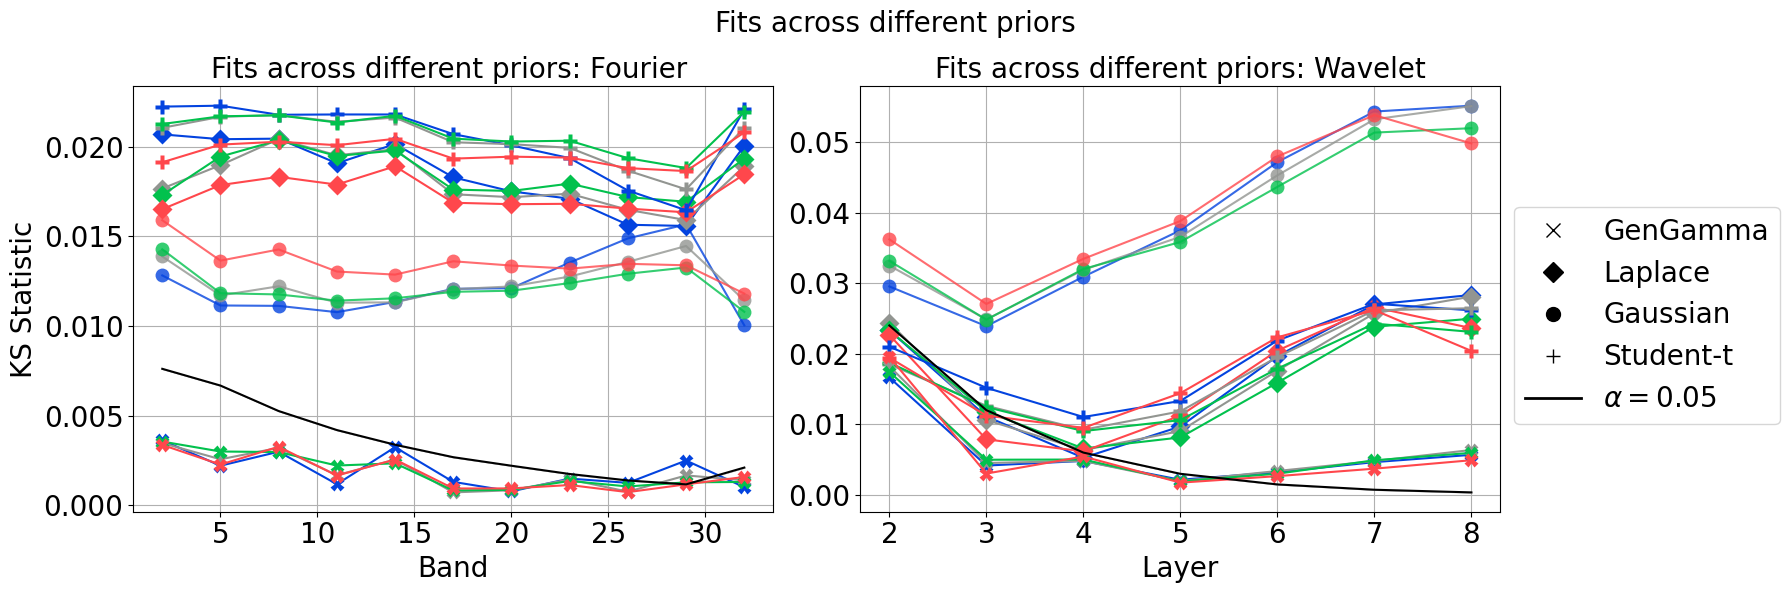

In [4]:
hue = 'channel'
dataset_name = 'pastis'
fixed_palette = {'gray': 'xkcd:gray','green': 'xkcd:shamrock green', 'red': 'xkcd:light red','blue': 'xkcd:blue'}

transform = 'fourier'
dataset_filter = (main_df['dataset'] == dataset_name)
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]
temp = temp.sort_values('kstest_stat_cutoff_0.05')

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle(f"Fits across different priors", fontsize=fontsize)

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[0], markersize = markersize, markeredgecolor='none')
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[0], markersize = markersize, markeredgecolor='none')
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[0], markersize = markersize, markeredgecolor='none')
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[0], markersize = markersize, markeredgecolor='none')
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[0])

x_lim_0 = axes[0].get_xlim()
y_lim_0 = axes[0].get_ylim()

axes[0].set_xlabel("Band", fontsize=fontsize)
axes[0].set_ylabel("KS Statistic", fontsize=fontsize)
axes[0].legend(points, labels, fontsize = 12).set_visible(False)
axes[0].grid(True)
axes[0].set_title("Fits across different priors: Fourier ", fontsize=fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=fontsize)

transform = 'wavelet'
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[1], markersize = markersize, markeredgecolor='none')
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[1], markersize = markersize, markeredgecolor='none')
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[1], markersize = markersize, markeredgecolor='none')
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[1], markersize = markersize, markeredgecolor='none')
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[1])

x_lim_1 = axes[1].get_xlim()
y_lim_1 = axes[1].get_ylim()

axes[1].set_xlabel("Layer", fontsize=fontsize)
axes[1].set_ylabel("", fontsize=fontsize)
axes[1].legend(points, labels, fontsize = 20, bbox_to_anchor = (1, 0.75))#.set_visible(False)
axes[1].grid(True)
axes[1].set_title("Fits across different priors: Wavelet", fontsize=fontsize)
axes[1].tick_params(axis='both', which='major', labelsize=fontsize)

if SAVE_FIGS:
    fig.figure.savefig(os.path.join(plots_path, f"cdss_ksstat_across_priors_{dataset_name}_line.jpg"), dpi=1000, bbox_inches='tight')

plt.tight_layout()
plt.show()

## Option 2: p-values represented as regions

In [5]:
fontsize = 20
markersize = 10
labelsize = 20
markertypes = ['x', 'D', 'o', '+']
labels = ['GenGamma', 'Laplace', 'Gaussian', 'Student-t', r'$\alpha\geq0.05$', r'$\alpha\geq0.10$']
points = [Line2D([0], [0], color='k', linestyle='', marker=m, markersize=10) for m in markertypes] + [
    Rectangle((0, 0), 1, 1, color='gray', alpha=0.5),
    Rectangle((0, 0), 1, 1, color='black', alpha=0.3)
]

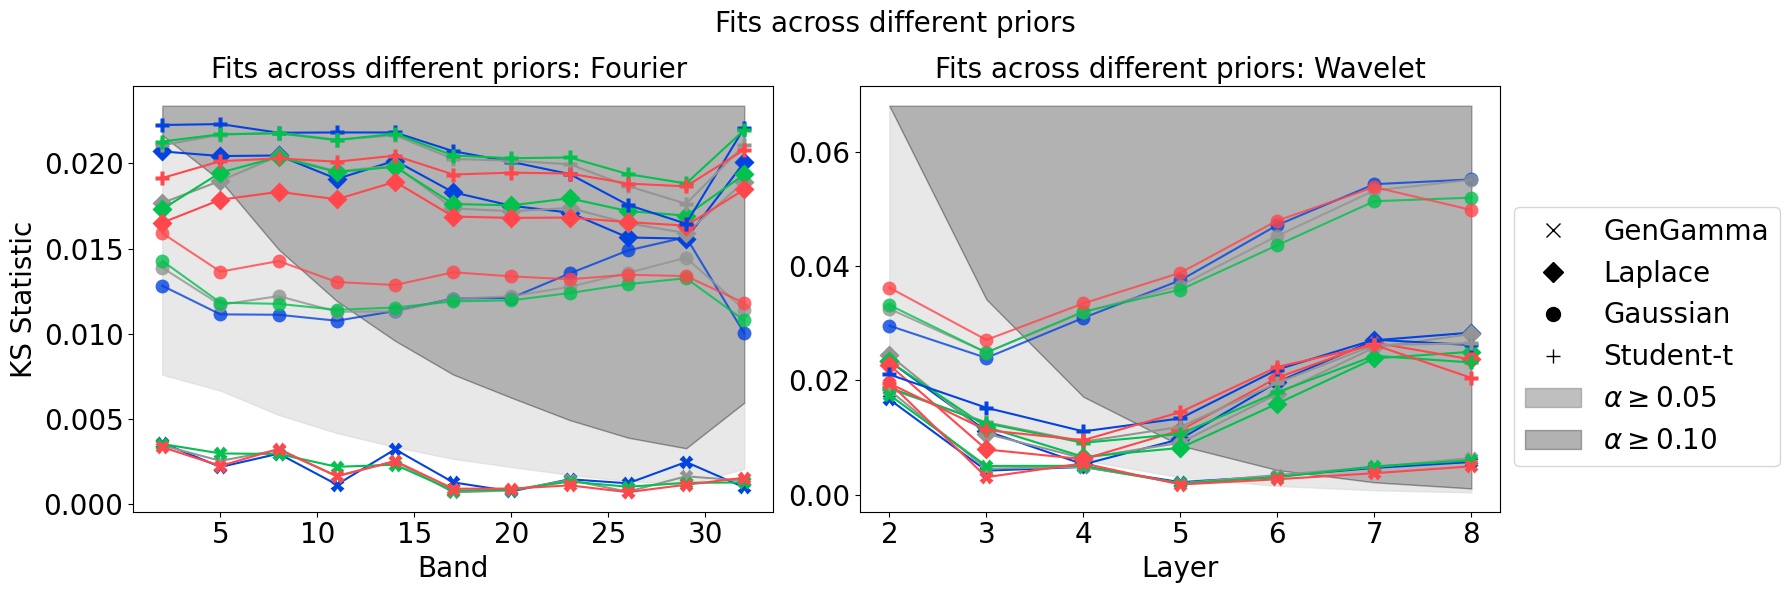

In [6]:
hue = 'channel'
dataset_name = 'pastis'
fixed_palette = {'gray': 'xkcd:gray','green': 'xkcd:shamrock green', 'red': 'xkcd:light red','blue': 'xkcd:blue'}

transform = 'fourier'
dataset_filter = (main_df['dataset'] == dataset_name)
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]
temp = temp.sort_values('kstest_stat_cutoff_0.05')

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle(f"Fits across different priors", fontsize=fontsize)

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[0], markersize = markersize, markeredgecolor='none')
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[0], markersize = markersize, markeredgecolor='none')
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[0], markersize = markersize, markeredgecolor='none')
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[0], markersize = markersize, markeredgecolor='none')
# sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[0])
# sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.10', color='black', ax=axes[0])

x_lim_0 = axes[0].get_xlim()
y_lim_0 = axes[0].get_ylim()
cutoff = temp.groupby('group').agg({'kstest_stat_cutoff_0.05' : 'first', 'kstest_stat_cutoff_0.10' : 'first'}).reset_index()
axes[0].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.05'], cutoff['kstest_stat_cutoff_0.10'], color='lightgrey', alpha=0.5)
axes[0].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.10'], max(y_lim_0[1], max(cutoff['kstest_stat_cutoff_0.10'])), color='black', alpha=0.3)

axes[0].set_xlabel("Band", fontsize=fontsize)
axes[0].set_ylabel("KS Statistic", fontsize=fontsize)
axes[0].legend(points, labels, fontsize = 12).set_visible(False)
# axes[0].grid(True)
axes[0].set_title("Fits across different priors: Fourier ", fontsize=fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=fontsize)

transform = 'wavelet'
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[1], markersize = markersize, markeredgecolor='none')
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[1], markersize = markersize, markeredgecolor='none')
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[1], markersize = markersize, markeredgecolor='none')
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[1], markersize = markersize, markeredgecolor='none')

x_lim_1 = axes[1].get_xlim()
y_lim_1 = axes[1].get_ylim()
cutoff = temp.groupby('group').agg({'kstest_stat_cutoff_0.05' : 'first', 'kstest_stat_cutoff_0.10' : 'first'}).reset_index()
axes[1].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.05'], cutoff['kstest_stat_cutoff_0.10'], color='lightgrey', alpha=0.5)
axes[1].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.10'], max(y_lim_1[1], max(cutoff['kstest_stat_cutoff_0.10'])), color='black', alpha=0.3)

axes[1].set_xlabel("Layer", fontsize=fontsize)
axes[1].set_ylabel("", fontsize=fontsize)
axes[1].legend(points, labels, fontsize = 20, bbox_to_anchor = (1, 0.75))#.set_visible(False)
# axes[1].grid(True)
axes[1].set_title("Fits across different priors: Wavelet", fontsize=fontsize)
axes[1].tick_params(axis='both', which='major', labelsize=fontsize)

if SAVE_FIGS:
    fig.figure.savefig(os.path.join(plots_path, f"cdss_ksstat_across_priors_{dataset_name}_region.jpg"), dpi=1000, bbox_inches='tight')

plt.tight_layout()
plt.show()